In [2]:
# use wandb artifact outside a run

import wandb

api = wandb.Api()
artifact = api.artifact('greatml/FedSPK/Artifact0.8790510733321198:v0')

datadir = artifact.download()

wandb:   1 of 1 files downloaded.  


In [3]:
datadir

'./artifacts/Artifact0.8790510733321198:v0'

In [17]:
def loadParameters(model, path, map_location="cuda:0"):

    self_state = model.state_dict()
    loaded_state = torch.load(path, map_location=map_location)

    for name, param in loaded_state.items():
        if '__L__.W' in name:
            continue
        
        origname = name
        if name not in self_state:
            name = name.replace("module.", "")
            if name not in self_state:
                name = "__S__."+name
                if name not in self_state:
                    print("#%s is not in the model."%origname)
                    continue

        if self_state[name].size() != loaded_state[origname].size():
            print("#Wrong parameter length: %s, model: %s, loaded: %s"%(origname, self_state[name].size(), loaded_state['model'][origname].size()))
            continue

        self_state[name].copy_(param)

In [5]:
# load the pytorch model

import torch

loaded_state = torch.load(datadir + '/STD: std_FL test compact testing, canoical.pth', map_location='cpu')

In [18]:
from src.SpeakerNet import SpeakerNet

model = SpeakerNet(model='X_vector', trainfunc='softmax', nPerSpeaker=1, Syncbatch=False, n_mels=40, nOut=192, spec_aug=False, nClasses=5994, additional_model=[True, False])


X_vector.py, Embedding size is 192,  Spec_aug False.
Initialised Softmax Loss


In [19]:
loadParameters(model, datadir + '/STD: std_FL test compact testing, canoical.pth')

In [23]:
import time
from src.DatasetLoader import loadWAV
import os, sys

def evaluateFromList(model, listfilename, print_interval=100, test_path='', num_eval=10, eval_frames=0, verbose=True):
    
    model = model.cuda()

    model.eval()
    
    labels       = []
    files       = []
    feats       = {}
    tstart      = time.time()

    ## Read all lines
    with open(listfilename) as listfile:
        while True:
            line = listfile.readline()
            if (not line):
                break

            data = line.split()

            files.append(data[1])
            labels.append(data[0])


    ## Save all features to file
    for idx, file in enumerate(files):

        inp1 = torch.FloatTensor(loadWAV(os.path.join(test_path,file), eval_frames, evalmode=True, num_eval=num_eval)).cuda()

        ref_feat = model.forward(inp1).detach().cpu()

        feats[file] = ref_feat

        telapsed = time.time() - tstart

        if (idx % print_interval == 0) and verbose:
            sys.stdout.write("\rReading %d of %d: %.2f Hz, embedding size %d"%(idx, len(files), idx/telapsed, ref_feat.size()[1]))

    tstart = time.time()

    return feats, labels

In [ ]:
import pickle

for i in range(12):
    feats, labels = evaluateFromList(model, "../flearn_data/G%d_ID/train_list_G%d_ID.txt"%(i+1,i+1))

    # save python objects feats and labels
    with open('..FL_log/feats_G%d_ID.pkl'%i, 'wb') as f:
        pickle.dump(feats, f)
    with open('..FL_log/labels_G%d_ID.pkl'%i, 'wb') as f:
        pickle.dump(labels, f)


# use the saved pickles to evaluate the t-SNE results

In [2]:
import pickle

# load pickle objects
with open('../FL_log/feats_G0_ID.pkl', 'rb') as f:
    feats = pickle.load(f)
with open('../FL_log/labels_G0_ID.pkl', 'rb') as f:
    labels = pickle.load(f)

In [54]:
def get_label_dict(labels):
    # construct a dict for labels, give each label a unique number
    label_dict = {}
    for i in range(len(labels)):
        if labels[i] not in label_dict:
            label_dict[labels[i]] = len(label_dict)
    return label_dict

In [78]:
import numpy as np

def get_numpy_feats_labels(feats, labels, label_dict, domain, total_speaker=40, per_speaker_utt=10):

    numpy_feats1 = np.zeros((0, 192))
    numpy_labels1 = np.zeros((0))

    same_label_count = 0
    label_last = -1
    for label, feat in zip(labels, feats):

        if label_dict[label] >= total_speaker:
            numpy_domains1 = np.array([domain]*numpy_labels1.shape[0])
            return numpy_feats1, numpy_labels1, numpy_domains1

        if label_last == label:
            if same_label_count == per_speaker_utt-1:
                continue
            same_label_count += 1
        else:
            same_label_count = 0

        numpy_feats1 = np.vstack((numpy_feats1, feat.numpy()))
        numpy_labels1 = np.append(numpy_labels1, label_dict[label])

        label_last = label

    numpy_domains1 = np.array([domain]*numpy_labels1.shape[0])

    return numpy_feats1, numpy_labels1, numpy_domains1

In [84]:
feats_total = []
labels_total = []
domains_total = []

for i in range(12):
    with open('../FL_log/feats_G%d_ID.pkl'%i, 'rb') as f:
        feats = pickle.load(f)
    with open('../FL_log/labels_G%d_ID.pkl'%i, 'rb') as f:
        labels = pickle.load(f)
    label_dict = get_label_dict(labels)
    numpy_feats1, numpy_labels1, numpy_domains1 = get_numpy_feats_labels(feats, labels, label_dict, i, 10, 10)
    feats_total.append(numpy_feats1)
    labels_total.append(numpy_labels1)
    domains_total.append(numpy_domains1)

In [85]:
# concate array in feats_total into one numpy array
feats_total_numpy = np.concatenate(feats_total, axis=0)

In [86]:
# concate array in labels_total into one numpy array
labels_total_numpy = np.concatenate(labels_total, axis=0)

In [87]:
# concate array in domains_total into one numpy array
domains_total_numpy = np.concatenate(domains_total, axis=0)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1200 samples in 0.001s...
[t-SNE] Computed neighbors for 1200 samples in 0.178s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1200
[t-SNE] Computed conditional probabilities for sample 1200 / 1200
[t-SNE] Mean sigma: 1.235248
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.351326
[t-SNE] KL divergence after 300 iterations: 1.076300


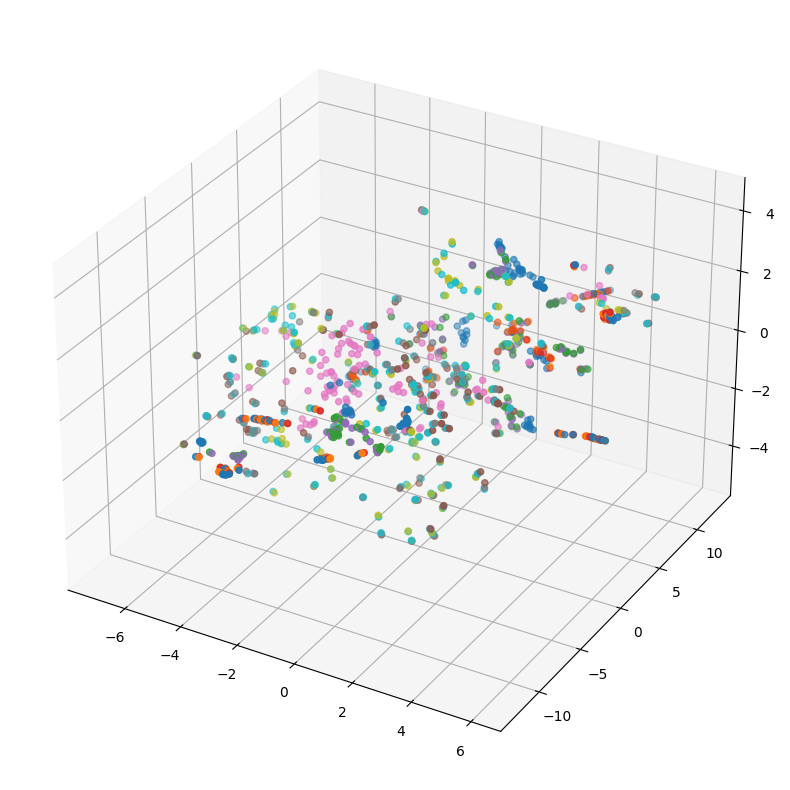

In [88]:
# use sklearn TSEN to visualize the embedding, 3D
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(feats_total_numpy)

# visualize the embedding
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_results[:,0], tsne_results[:,1], tsne_results[:,2], c=domains_total_numpy, cmap='tab10')
plt.show()

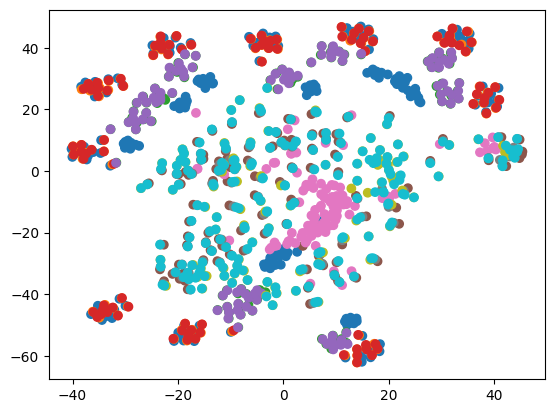

In [90]:
# use sklearn TSEN to visualize the embedding
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# create TSNE model
tsne = TSNE(n_components=2, random_state=0)

# use TSNE to reduce dimension for embedding
embedding_2d = tsne.fit_transform(feats_total_numpy)

# visualize the embedding
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=domains_total_numpy, cmap='tab10')
plt.show()

In [91]:
feats_total = []
labels_total = []
domains_total = []

for i in range(12):
    with open('../FL_log/feats_G%d_ID_Cent.pkl'%i, 'rb') as f:
        feats = pickle.load(f)
    with open('../FL_log/labels_G%d_ID_Cent.pkl'%i, 'rb') as f:
        labels = pickle.load(f)
    label_dict = get_label_dict(labels)
    numpy_feats1, numpy_labels1, numpy_domains1 = get_numpy_feats_labels(feats, labels, label_dict, i, 10, 10)
    feats_total.append(numpy_feats1)
    labels_total.append(numpy_labels1)
    domains_total.append(numpy_domains1)

In [92]:
# concate array in feats_total into one numpy array
feats_total_numpy = np.concatenate(feats_total, axis=0)

In [93]:
# concate array in labels_total into one numpy array
labels_total_numpy = np.concatenate(labels_total, axis=0)

In [94]:
# concate array in domains_total into one numpy array
domains_total_numpy = np.concatenate(domains_total, axis=0)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1200 samples in 0.001s...
[t-SNE] Computed neighbors for 1200 samples in 0.123s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1200
[t-SNE] Computed conditional probabilities for sample 1200 / 1200
[t-SNE] Mean sigma: 0.685382
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.013344
[t-SNE] KL divergence after 300 iterations: 1.453667


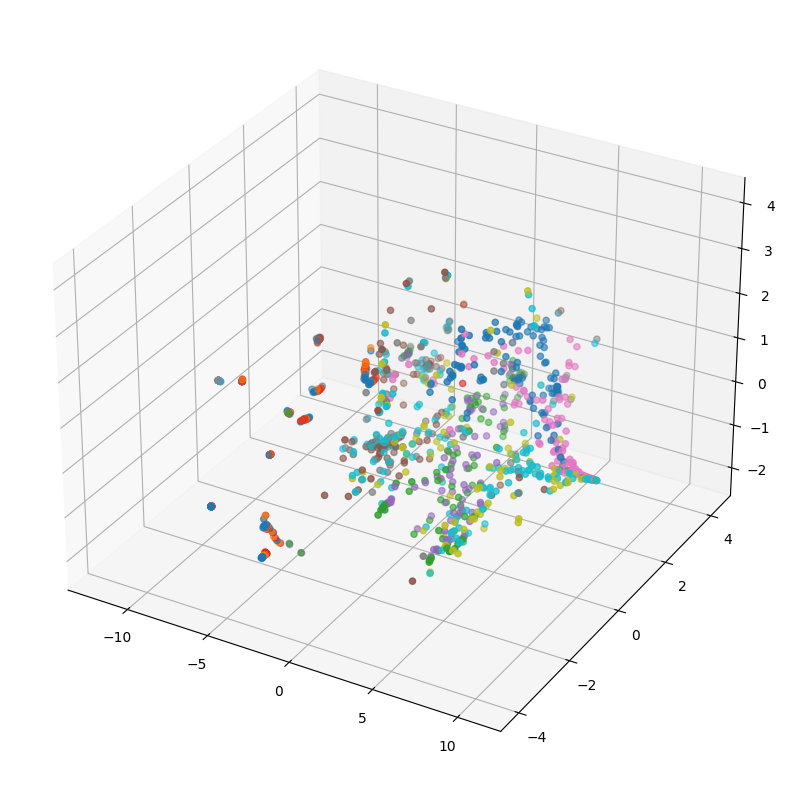

In [95]:
# use sklearn TSEN to visualize the embedding, Cent, 3D
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(feats_total_numpy)

# visualize the embedding
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_results[:,0], tsne_results[:,1], tsne_results[:,2], c=domains_total_numpy, cmap='tab10')
plt.show()

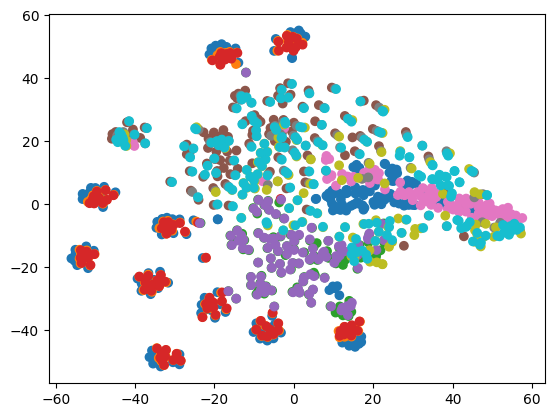

In [96]:
# use sklearn TSEN to visualize the embedding Cent
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# create TSNE model
tsne = TSNE(n_components=2, random_state=0)

# use TSNE to reduce dimension for embedding
embedding_2d = tsne.fit_transform(feats_total_numpy)

# visualize the embedding
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=domains_total_numpy, cmap='tab10')
plt.show()

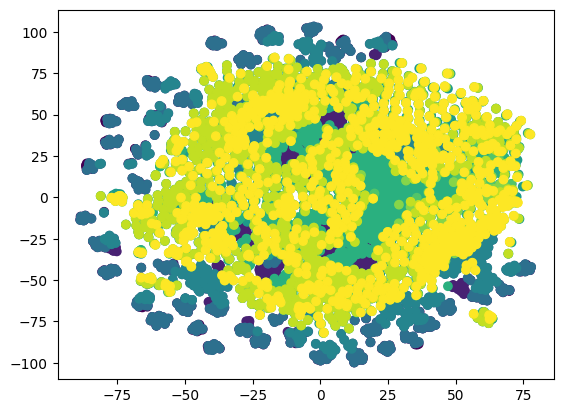

In [70]:
# use sklearn TSEN to visualize the embedding
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# create TSNE model
tsne = TSNE(n_components=2, random_state=0)

# use TSNE to reduce dimension for embedding
embedding_2d = tsne.fit_transform(feats_total_numpy)

# visualize the embedding
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=domains_total_numpy, cmap='tab10')
plt.show()

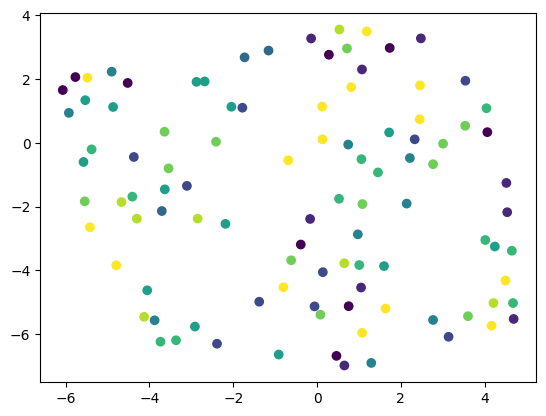

In [1]:
# use sklearn TSEN to visualize the embedding
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# create random embedding and class label
embedding = np.random.rand(100, 2)
label = np.random.randint(0, 10, 100)

# create TSNE model
tsne = TSNE(n_components=2, random_state=0)

# use TSNE to reduce dimension for embedding
embedding_2d = tsne.fit_transform(embedding)

# visualize the embedding
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], c=label)
plt.show()